In [149]:
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split


In [150]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
df = [train, test]


In [151]:
for data in df:
    data['date'] = pd.to_datetime(data['date'])
    #data['year'] = data.date.dt.year
    data['month'] = data.date.dt.month
    data['day'] = data.date.dt.day
    data['dayofyear'] = data.date.dt.dayofyear
    data['dayofweek'] = data.date.dt.dayofweek
    #data['dayofmonth'] = data.date.dt.day
    data['weekofyear'] = data.date.dt.weekofyear
    data['is_month_start'] = (data.date.dt.is_month_start).astype(int)
    data['is_month_end'] = (data.date.dt.is_month_end).astype(int)
    data.drop('date', axis=1, inplace=True)
    
    

In [152]:
def avg(dataf):
    dataf['dayofweek_avg']=dataf.groupby(['item','store','dayofweek'])['sales'].transform('mean')
    dataf['monthly_avg']=dataf.groupby(['item','store','month'])['sales'].transform('mean')
    return dataf
train = avg(train).dropna()

dayofweek_avg = train.groupby(['item','store','dayofweek'])['sales'].mean().reset_index()
monthly_avg = train.groupby(['item','store','month'])['sales'].mean().reset_index()

def combine(dataf,new_dataf,col,col_name):
    dataf =pd.merge(dataf, new_dataf, how='left', on=None, left_on=col, right_on=col, left_index=False, right_index=False, sort=True, copy=True, indicator=False,validate=None)
    dataf=dataf.rename(columns={'sales':col_name})
    return dataf

test = combine(test, dayofweek_avg,['item','store','dayofweek'],'dayofweek_avg')
test = combine(test, monthly_avg,['item','store','month'],'monthly_avg')


In [153]:
datf = train.groupby(['item','store'])['sales'].rolling(10).mean().reset_index()
train['rmean'] = datf['sales']

rmean_test = train.groupby(['item','store'])['rmean'].tail(90).copy().reset_index().drop('index', axis=1)
test['rmean'] = rmean_test

train['rmean'] = train.groupby(['item','store'])['rmean'].shift(90)

# dataf = train.groupby(['item','store'])['sales'].rolling(10).median().reset_index()
# train['rmedian'] = dataf['sales']

# rmedian_test = train.groupby(['item','store'])['rmedian'].tail(90).copy().reset_index().drop('index', axis=1)
# test['rmedian'] = rmedian_test

# train['rmedian'] = train.groupby(['item','store'])['rmedian'].shift(90)

In [154]:
# train.columns,test.columns
# print(train.head())
# print(train.tail())
# print(test.head())
# print(test.tail())

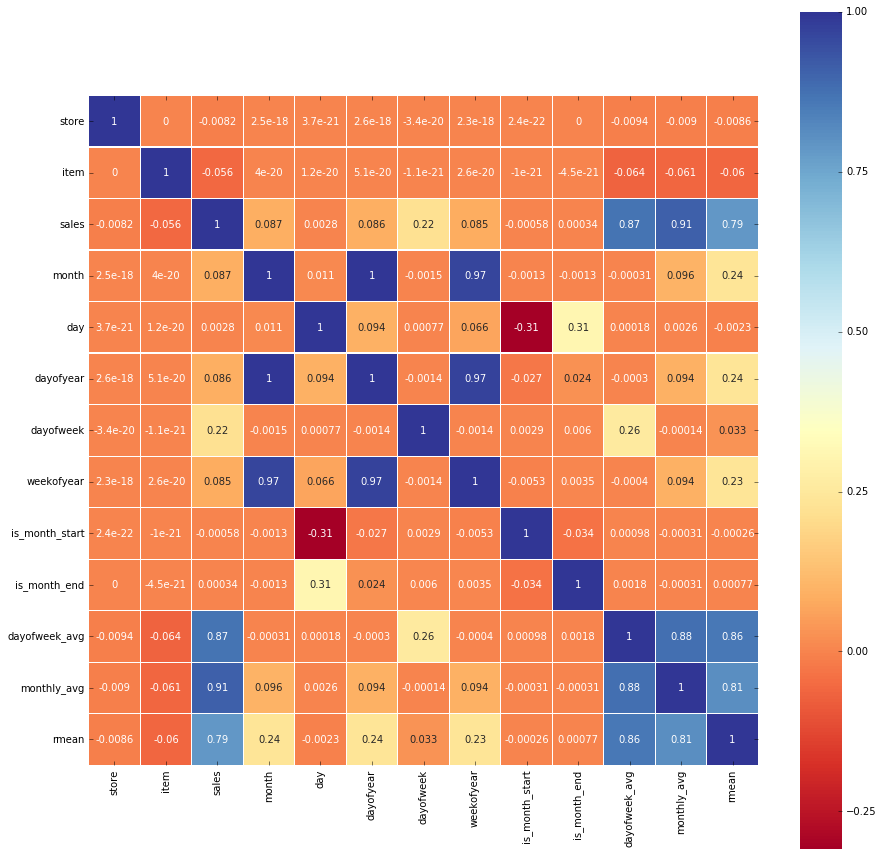

In [155]:
colormap = plt.cm.RdYlBu
plt.figure(figsize=(15,15))
sns.heatmap(train.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

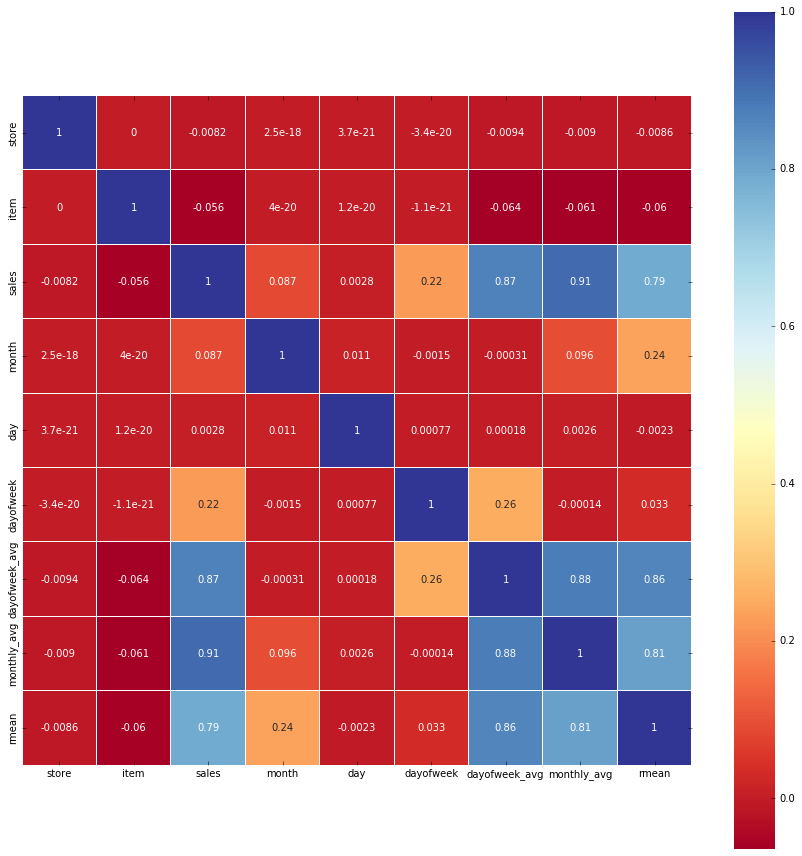

In [156]:
df = [train,test]
for data in df:
    data.drop([#'item',
               #'store',
               'dayofyear', 
               'weekofyear',
               #'day',
               #'month',
               #'dayofweek',
               'is_month_end',
               'is_month_start',
               #'dayofweek_avg',
               #'monthly_avg',
               #'rmean',
               #'rmedian'
               ],
               axis=1, 
               inplace=True)
    
colormap = plt.cm.RdYlBu
plt.figure(figsize=(15,15))
sns.heatmap(train.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [157]:
temp_sales = train['sales']
temp_id = test['id']
train = (train - train.mean()) / train.std()
test = (test - test.mean()) / test.std()
train['sales'] = temp_sales
test['id'] = temp_id
#train.head()


In [158]:
x_train,x_test,y_train,y_test = train_test_split(train.drop('sales',axis=1),train.pop('sales'),random_state=123,test_size=0.2)
test.sort_values(by=['id'], inplace=True)
x_pred = test.drop('id', axis=1)
#x_train.shape,y_train.shape,x_test.shape,y_test.shape


In [159]:
def model(x_train,y_train,x_test,y_test):
    params = {
        'max_depth': 8,
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression_l1',
        'metric': 'mape',
        'num_leaves': 35,
        'learning_rate': 0.2,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'lambda_l1': 3,
        'lambda_l2': 3,
        'verbose': -1
            }
    lgb_train = lgb.Dataset(x_train,y_train)
    lgb_valid = lgb.Dataset(x_test,y_test)
    model = lgb.train(params, lgb_train, 3000, valid_sets=[lgb_train, lgb_valid],early_stopping_rounds=50, verbose_eval=50)
    y_pred = model.predict(x_pred)
    return y_pred,model

y_pred, model = model(x_train,y_train,x_test,y_test)

Training until validation scores don't improve for 50 rounds.
[50]	training's mape: 0.137462	valid_1's mape: 0.13797
[100]	training's mape: 0.13525	valid_1's mape: 0.136001
[150]	training's mape: 0.134535	valid_1's mape: 0.135606
[200]	training's mape: 0.134065	valid_1's mape: 0.135484
[250]	training's mape: 0.13367	valid_1's mape: 0.135418
[300]	training's mape: 0.133272	valid_1's mape: 0.135384
Early stopping, best iteration is:
[299]	training's mape: 0.133279	valid_1's mape: 0.135381


In [160]:
submission = pd.DataFrame({"id": test['id'], "sales": y_pred.round()})
submission.to_csv('sub1.csv',index=False)
submission.head()

,id,sales
0,0,13.0
5,1,14.0
10,2,14.0
15,3,16.0
19,4,17.0
